In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,

    classification_report,
    confusion_matrix,
    top_k_accuracy_score
)
from catboost import CatBoostClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_dataset(file_path):
    """
    Load the farm animal disease dataset from CSV.

    Args:
        file_path: Path to the CSV file

    Returns:
        DataFrame with the dataset
    """
    print(f"Loading dataset from {file_path}...")
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully. Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        print(f"\nFirst few rows:")
        print(df.head())
        return df
    except Exception as e:
        raise FileNotFoundError(f"Error loading dataset: {e}")

def preprocess_data(df):
    """
    Preprocess the dataset:
    - Clean symptoms text
    - Encode categorical variables
    - Create feature matrix

    Args:
        df: Input DataFrame

    Returns:
        Tuple of (X, y, tfidf, animal_encoder, disease_encoder)
    """
    print("\n" + "="*60)
    print("PREPROCESSING DATA")
    print("="*60)

    # Make a copy to avoid modifying original
    df = df.copy()

    # Check for missing values
    if df.isnull().any().any():
        print("Warning: Found missing values. Dropping rows with missing data...")
        df = df.dropna()

    print(f"\nDataset shape after cleaning: {df.shape}")

    # Convert symptoms to clean text (replace ", " with " ")
    print("\nProcessing symptoms text...")
    df['symptoms_text'] = df['Symptoms'].apply(lambda x: str(x).replace(", ", " "))

    # Encode Animal using LabelEncoder
    print("\nEncoding Animal feature...")
    animal_encoder = LabelEncoder()
    df['animal_encoded'] = animal_encoder.fit_transform(df['Animal'])
    print(f"Animal classes: {animal_encoder.classes_}")

    # Encode Disease labels
    print("\nEncoding Disease labels...")
    disease_encoder = LabelEncoder()
    y = disease_encoder.fit_transform(df['Disease'])
    print(f"Number of disease classes: {len(disease_encoder.classes_)}")
    print(f"Disease classes: {disease_encoder.classes_[:10]}..." if len(disease_encoder.classes_) > 10
          else f"Disease classes: {disease_encoder.classes_}")

    # TF-IDF vectorization for symptoms
    print("\nApplying TF-IDF vectorization on symptoms...")
    tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.98
    )

    symptoms_tfidf = tfidf.fit_transform(df['symptoms_text'])
    print(f"TF-IDF matrix shape: {symptoms_tfidf.shape}")

    # Combine TF-IDF features with encoded animal feature
    print("\nCombining TF-IDF features with Animal encoding...")
    animal_feature = df['animal_encoded'].values.reshape(-1, 1)

    # Convert sparse matrix to dense and concatenate
    from scipy.sparse import hstack
    X = hstack([symptoms_tfidf, animal_feature])
    print(f"Final feature matrix shape: {X.shape}")

    return X, y, tfidf, animal_encoder, disease_encoder

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)


In [5]:
DATA_PATH = "farm_animal_disease_dataset_20000_96plus.csv"

df = pd.read_csv(DATA_PATH)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (20000, 3)


,Animal,Symptoms,Disease
0,Buffalo,"Incoordination, Paralysis, Eye discharge",Listeriosis
1,Cow,"Diarrhoea, Bloody diarrhoea, Weakness, Dullnes...",Coccidiosis
2,Cow,"Bloody diarrhoea, High fever, Dehydration, Sud...",Rinderpest
3,Cow,"Foamy saliva, Nasal bleeding, High fever, Depr...",Anthrax
4,Cow,"Eye discharge, Swollen lymph nodes, Reduced mi...",Lumpy Skin Disease (Lumpy Virus)


In [6]:
print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Counts:")
print("Animals:", df["Animal"].nunique())
print("Diseases:", df["Disease"].nunique())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Animal    20000 non-null  object
 1   Symptoms  20000 non-null  object
 2   Disease   20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB
None

Missing Values:
Animal      0
Symptoms    0
Disease     0
dtype: int64

Unique Counts:
Animals: 4
Diseases: 32


In [9]:
df["Symptoms_list"] = df["Symptoms"].apply(
    lambda x: [s.strip() for s in str(x).split(",")]
)

df["Symptom_count"] = df["Symptoms_list"].apply(len)


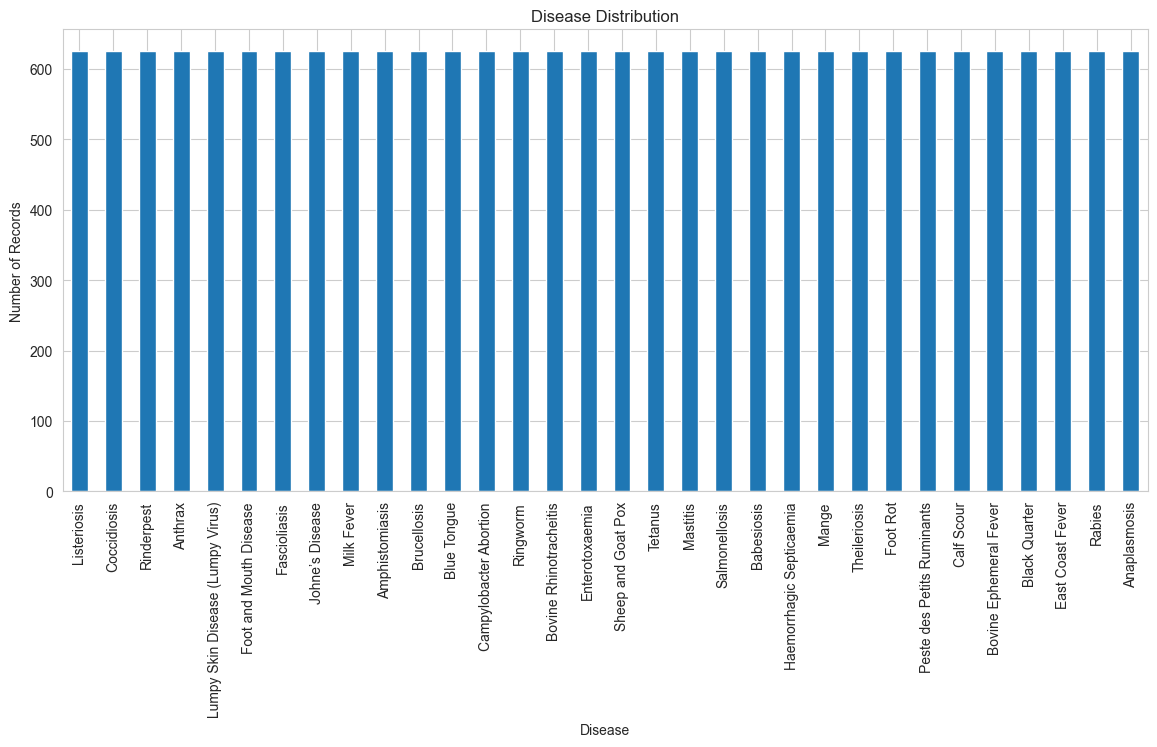

In [10]:
plt.figure(figsize=(14,6))
df["Disease"].value_counts().plot(kind="bar")
plt.title("Disease Distribution")
plt.xlabel("Disease")
plt.ylabel("Number of Records")
plt.xticks(rotation=90)
plt.show()


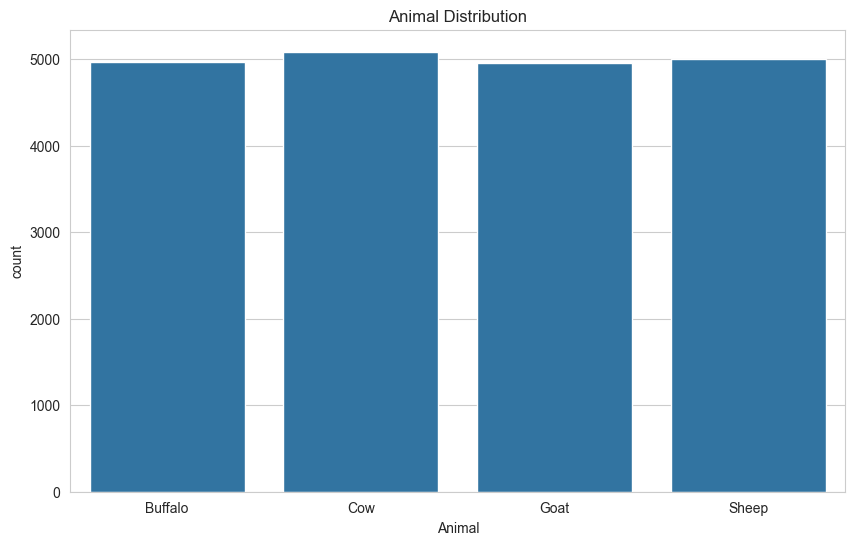

In [11]:
sns.countplot(data=df, x="Animal")
plt.title("Animal Distribution")
plt.show()


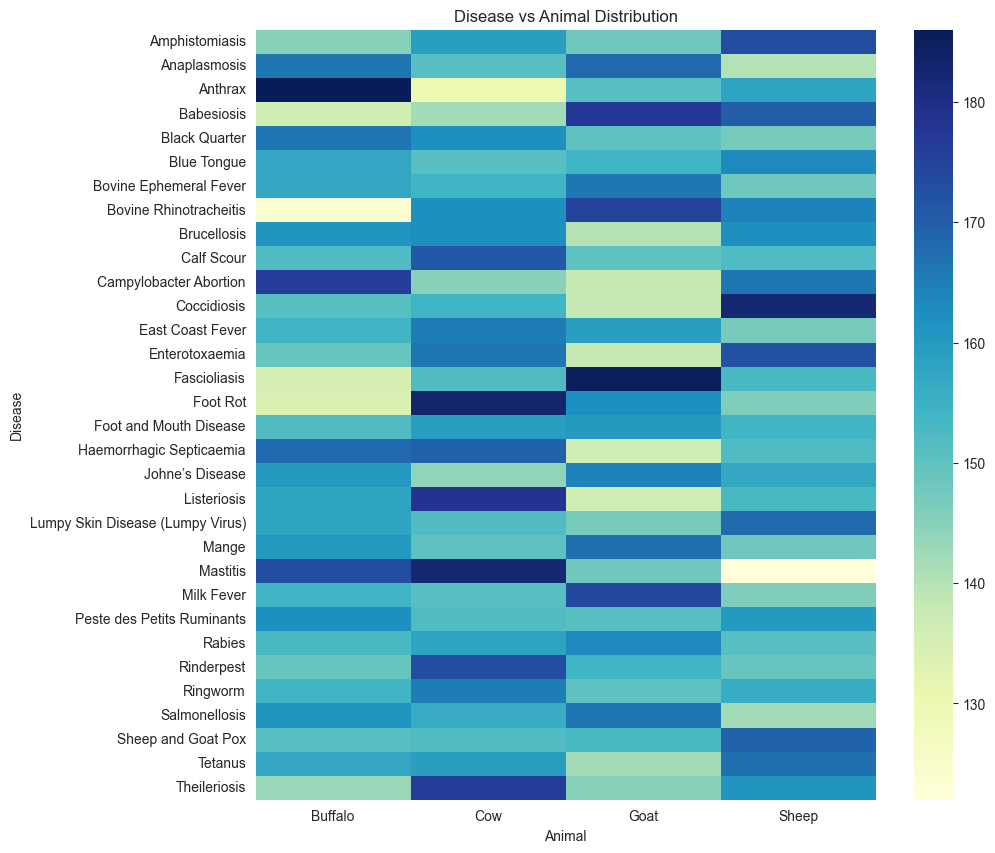

In [12]:
cross_tab = pd.crosstab(df["Disease"], df["Animal"])

plt.figure(figsize=(10,10))
sns.heatmap(cross_tab, cmap="YlGnBu")
plt.title("Disease vs Animal Distribution")
plt.show()


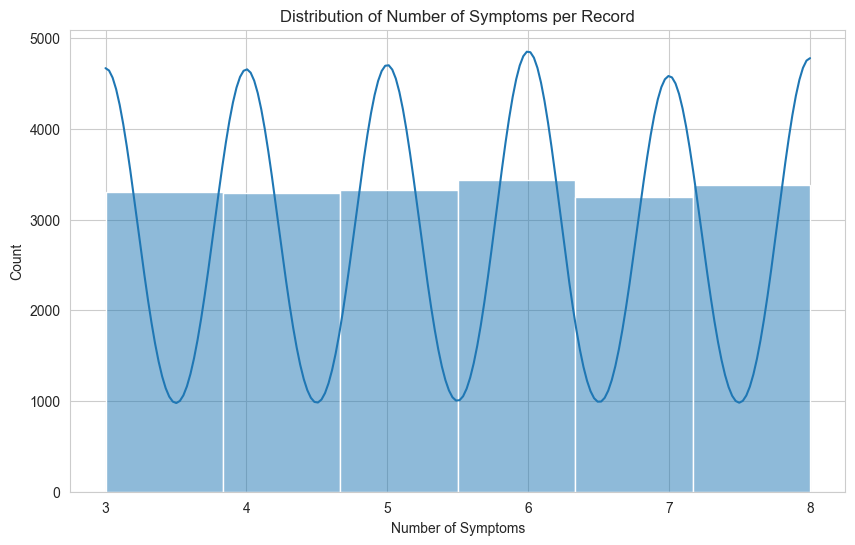

In [13]:
sns.histplot(df["Symptom_count"], bins=6, kde=True)
plt.title("Distribution of Number of Symptoms per Record")
plt.xlabel("Number of Symptoms")
plt.show()


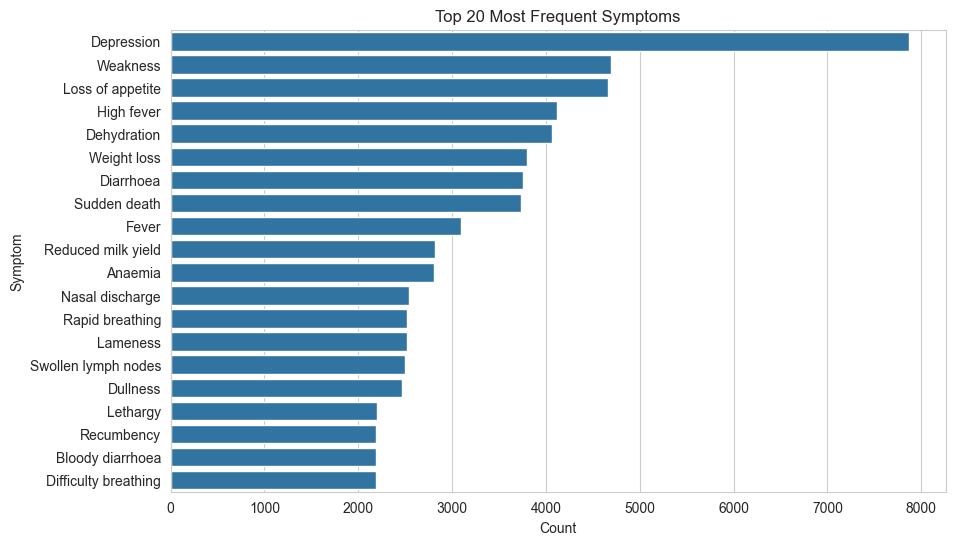

In [14]:
from collections import Counter

symptom_counter = Counter()

for lst in df["Symptoms_list"]:
    symptom_counter.update(lst)

top_symptoms = pd.DataFrame(
    symptom_counter.most_common(20),
    columns=["Symptom", "Count"]
)

sns.barplot(data=top_symptoms, y="Symptom", x="Count")
plt.title("Top 20 Most Frequent Symptoms")
plt.show()


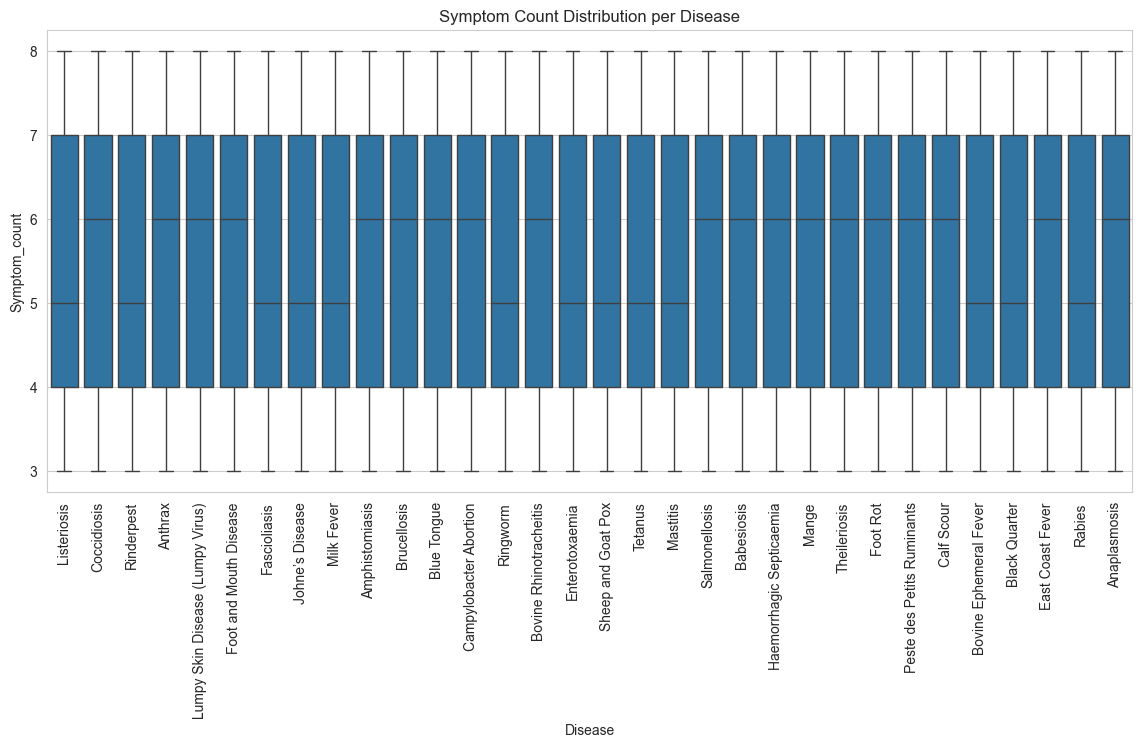

In [15]:
plt.figure(figsize=(14,6))
sns.boxplot(x="Disease", y="Symptom_count", data=df)
plt.xticks(rotation=90)
plt.title("Symptom Count Distribution per Disease")
plt.show()


In [17]:
disease_symptoms = {}

for disease in df["Disease"].unique():
    s = set()
    for lst in df[df["Disease"] == disease]["Symptoms_list"]:
        s.update(lst)
    disease_symptoms[disease] = s

common_symptoms = set.intersection(*disease_symptoms.values())

print("Symptoms common to ALL diseases:", len(common_symptoms))
print(common_symptoms)


Symptoms common to ALL diseases: 0
set()


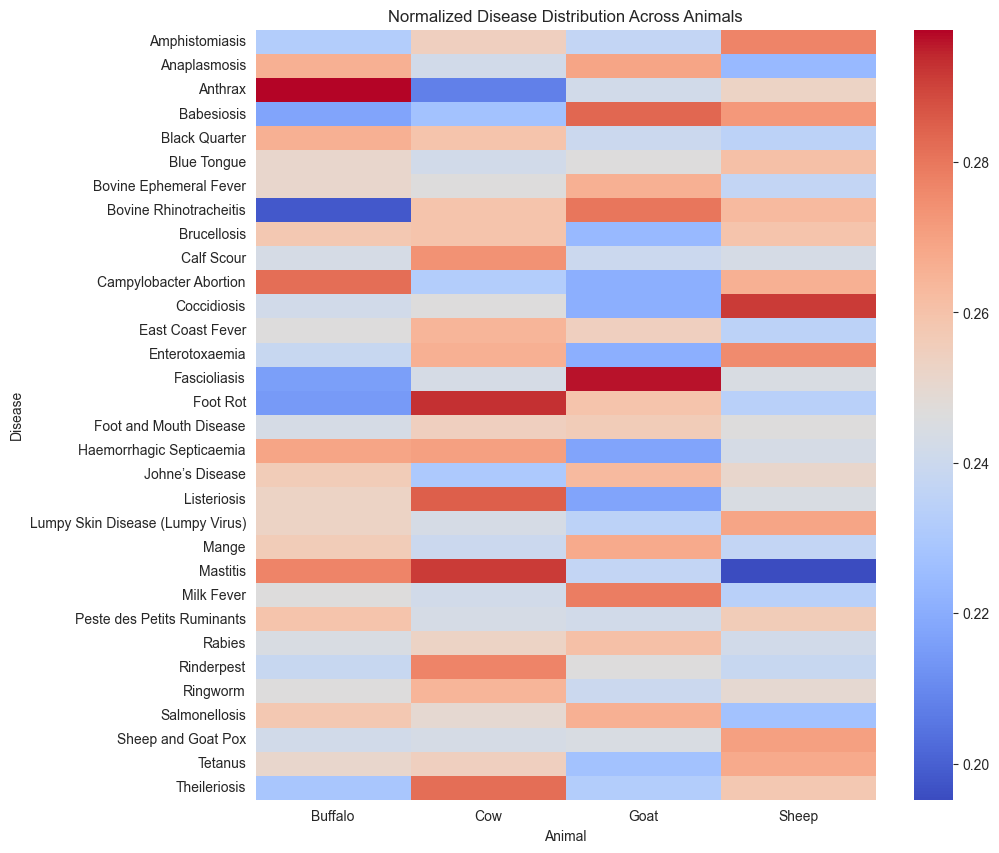

In [18]:
disease_animal = pd.crosstab(df["Disease"], df["Animal"], normalize="index")

plt.figure(figsize=(10,10))
sns.heatmap(disease_animal, cmap="coolwarm", annot=False)
plt.title("Normalized Disease Distribution Across Animals")
plt.show()


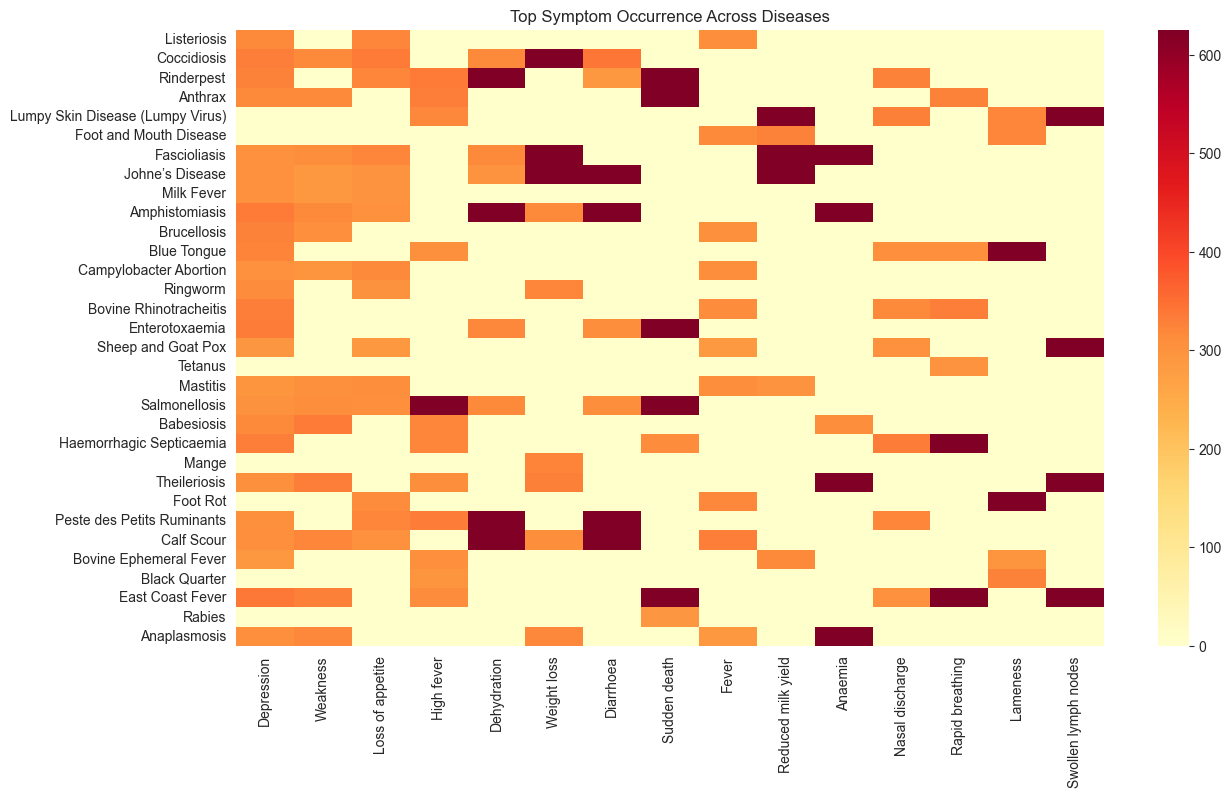

In [19]:
from collections import Counter

# top 15 symptoms
symptom_counter = Counter()
for lst in df["Symptoms_list"]:
    symptom_counter.update(lst)

top15 = [s for s,_ in symptom_counter.most_common(15)]

# build matrix
rows = []
for disease in df["Disease"].unique():
    disease_rows = df[df["Disease"] == disease]["Symptoms_list"]
    counts = {s:0 for s in top15}
    for lst in disease_rows:
        for s in lst:
            if s in counts:
                counts[s]+=1
    rows.append(counts)

heat_df = pd.DataFrame(rows, index=df["Disease"].unique())

plt.figure(figsize=(14,8))
sns.heatmap(heat_df, cmap="YlOrRd")
plt.title("Top Symptom Occurrence Across Diseases")
plt.show()


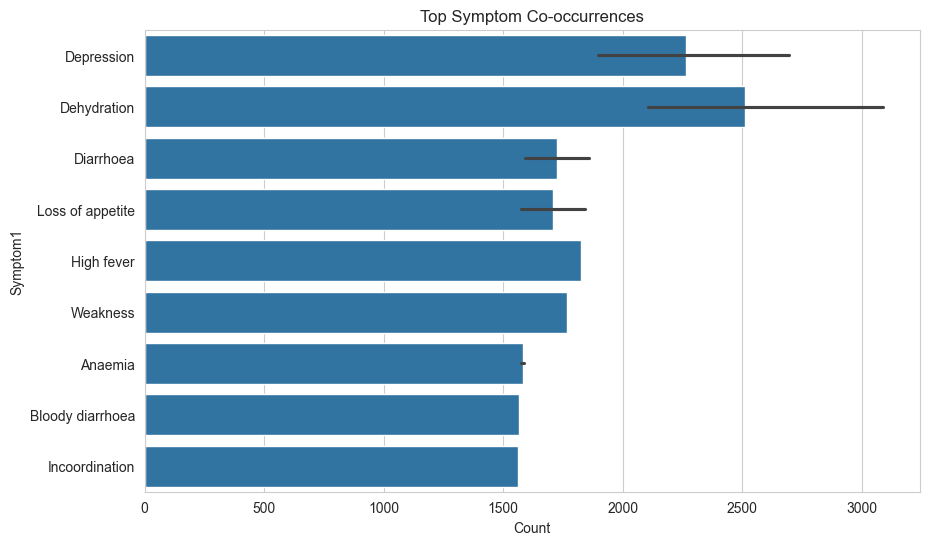

In [20]:
from itertools import combinations
from collections import defaultdict

co_occurrence = defaultdict(int)

for symptoms in df["Symptoms_list"]:
    for pair in combinations(sorted(symptoms), 2):
        co_occurrence[pair] += 1

co_df = pd.DataFrame(
    [(k[0], k[1], v) for k,v in co_occurrence.items()],
    columns=["Symptom1","Symptom2","Count"]
)

top_pairs = co_df.sort_values("Count", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_pairs, x="Count", y="Symptom1")
plt.title("Top Symptom Co-occurrences")
plt.show()


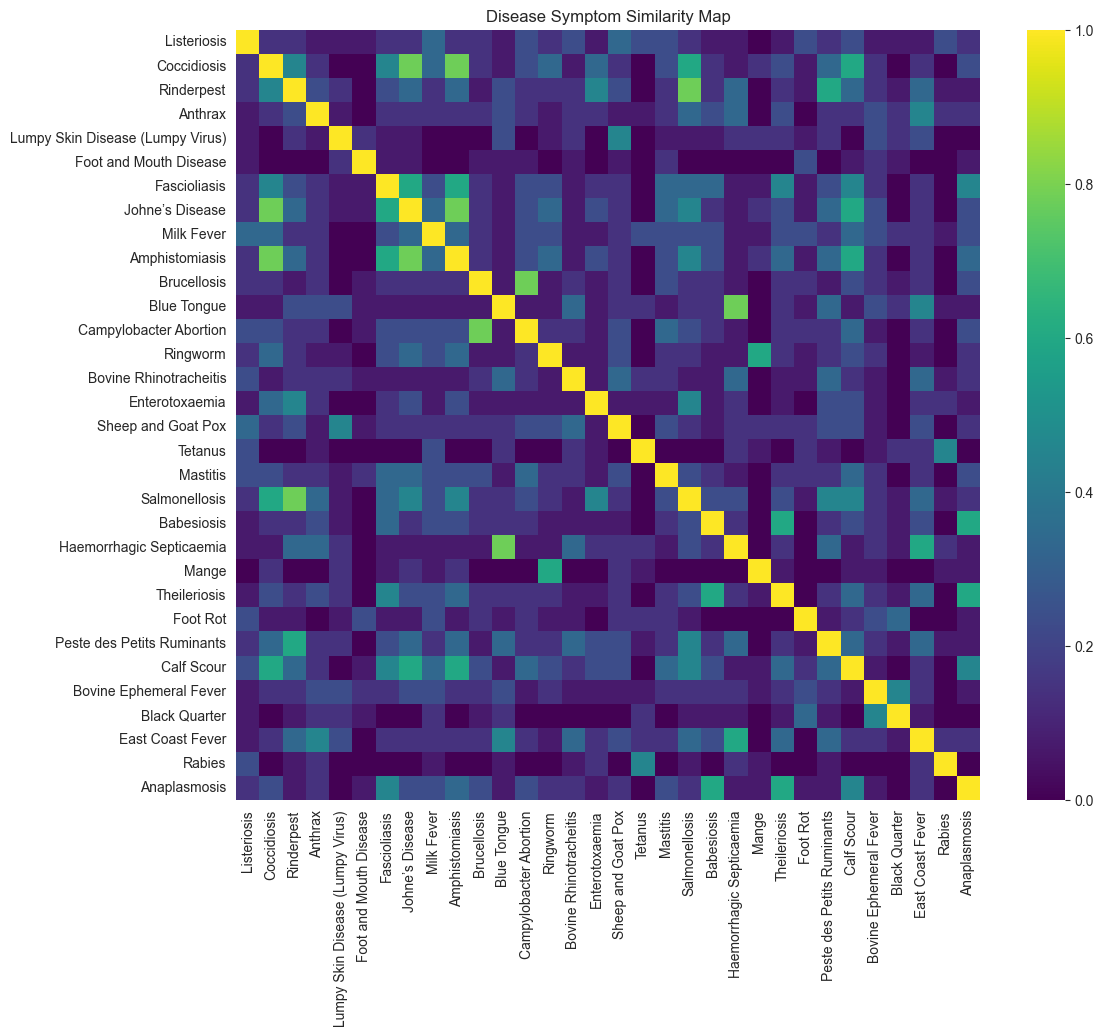

In [21]:
disease_symptoms = {}

for disease in df["Disease"].unique():
    s = set()
    for lst in df[df["Disease"] == disease]["Symptoms_list"]:
        s.update(lst)
    disease_symptoms[disease] = s

diseases = list(disease_symptoms.keys())

similarity_matrix = np.zeros((len(diseases), len(diseases)))

for i in range(len(diseases)):
    for j in range(len(diseases)):
        a = disease_symptoms[diseases[i]]
        b = disease_symptoms[diseases[j]]
        similarity_matrix[i,j] = len(a & b) / len(a | b)

plt.figure(figsize=(12,10))
sns.heatmap(similarity_matrix,
            xticklabels=diseases,
            yticklabels=diseases,
            cmap="viridis")
plt.title("Disease Symptom Similarity Map")
plt.xticks(rotation=90)
plt.show()


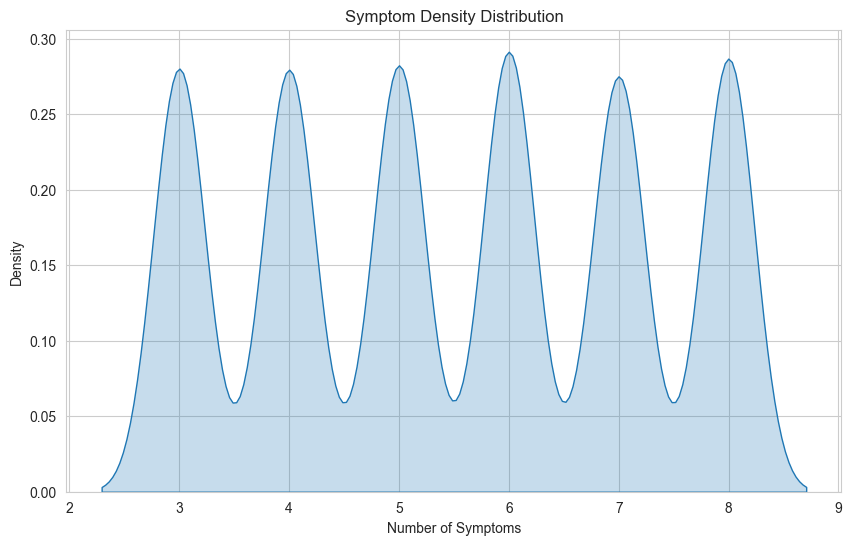

In [22]:
sns.kdeplot(df["Symptom_count"], fill=True)
plt.title("Symptom Density Distribution")
plt.xlabel("Number of Symptoms")
plt.show()


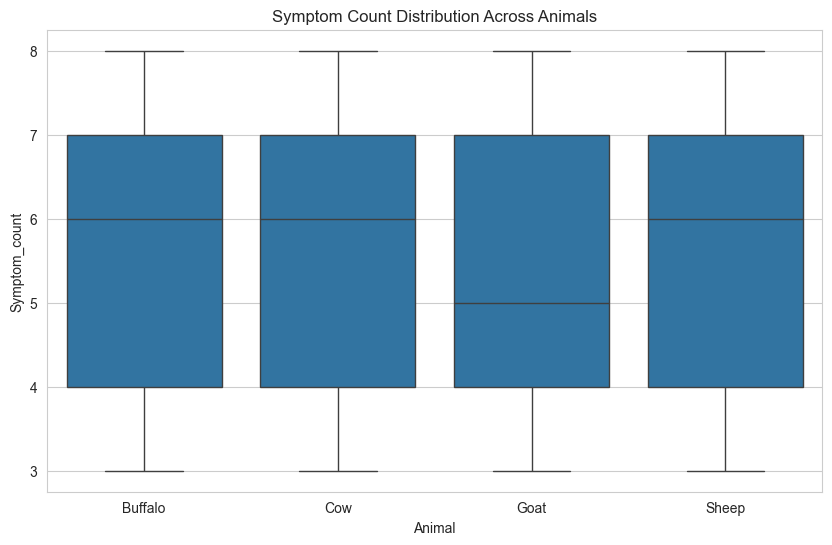

In [23]:
sns.boxplot(data=df, x="Animal", y="Symptom_count")
plt.title("Symptom Count Distribution Across Animals")
plt.show()


In [ ]:
def create_base_models():
    """
    Create and configure the three base models for the ensemble.

    Returns:
        List of tuples (name, model)
    """
    print("\n" + "="*60)
    print("CREATING BASE MODELS")
    print("="*60)

    # Model 1: Random Forest
    print("\n1. Random Forest Classifier")
    rf_model = RandomForestClassifier(
    n_estimators=120,
    max_depth=None,
    random_state=42,
    n_jobs=-1
    )


    # Model 2: SVC with scaling pipeline
    from sklearn.linear_model import LogisticRegression

    svc_model = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', SVC(
        kernel='linear',        # KEY CHANGE
        probability=True,
        random_state=42
    ))
    ])



    # Model 3: CatBoost
    print("3. CatBoost Classifier")
    catboost_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=False,
    thread_count=-1,
    loss_function='MultiClass'
    )


    models = [
        ('random_forest', rf_model),
        ('svc', svc_model),
        ('catboost', catboost_model)
    ]

    return models

def train_ensemble(X_train, y_train, base_models):
    """
    Train the hybrid ensemble using VotingClassifier with soft voting.

    Args:
        X_train: Training features
        y_train: Training labels
        base_models: List of base models

    Returns:
        Trained VotingClassifier
    """
    print("\n" + "="*60)
    print("TRAINING HYBRID ENSEMBLE")
    print("="*60)

    # Create VotingClassifier with soft voting
    ensemble = VotingClassifier(
        estimators=base_models,
        voting='soft',
        n_jobs=1
    )

    print("\nTraining ensemble model...")
    print("This may take a few minutes depending on dataset size...")
    

    ensemble.fit(X_train, y_train)

    print("\nTraining completed successfully!")

    return ensemble

def evaluate_model(model, X_test, y_test, disease_encoder):
    """
    Evaluate the trained model and print metrics.

    Args:
        model: Trained model
        X_test: Test features
        y_test: Test labels
        disease_encoder: LabelEncoder for disease names
    """
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)

    # Make predictions
    print("\nMaking predictions on test set...")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{'='*60}")
    print(f"ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"{'='*60}")

    # Classification report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    report = classification_report(
        y_test,
        y_pred,
        target_names=disease_encoder.classes_,
        digits=4,
        zero_division=0
    )
    print(report)

    # Confusion matrix
    print("\n" + "="*60)
    print("CONFUSION MATRIX")
    print("="*60)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Top-3 accuracy
    try:
        top3_acc = top_k_accuracy_score(y_test, y_pred_proba, k=3)
        print("\n" + "="*60)
        print(f"TOP-3 ACCURACY: {top3_acc:.4f} ({top3_acc*100:.2f}%)")
        print("="*60)
    except Exception as e:
        print(f"\nNote: Could not calculate top-3 accuracy: {e}")

    return accuracy, y_pred, cm

def save_artifacts(model, tfidf, animal_encoder, disease_encoder):
    """
    Save the trained model and encoders using joblib.

    Args:
        model: Trained ensemble model
        tfidf: Fitted TfidfVectorizer
        animal_encoder: Fitted LabelEncoder for animals
        disease_encoder: Fitted LabelEncoder for diseases
    """
    print("\n" + "="*60)
    print("SAVING MODEL ARTIFACTS")
    print("="*60)

    artifacts = {
        'hybrid_model.pkl': model,
        'tfidf.pkl': tfidf,
        'animal_encoder.pkl': animal_encoder,
        'disease_encoder.pkl': disease_encoder
    }

    for filename, artifact in artifacts.items():
        try:
            joblib.dump(artifact, filename)
            print(f"✓ Saved: {filename}")
        except Exception as e:
            print(f"✗ Error saving {filename}: {e}")

    print("\nAll artifacts saved successfully!")

In [2]:
def main():
    """
    Main training pipeline.
    """
    print("\n" + "="*60)
    print("FARM ANIMAL DISEASE PREDICTION - HYBRID ENSEMBLE TRAINING")
    print("="*60)

    # Configuration
    DATA_PATH = 'farm_animal_disease_dataset_20000_96plus.csv'
    TEST_SIZE = 0.2
    RANDOM_STATE = 42

    try:
        # Step 1: Load dataset
        df = load_dataset(DATA_PATH)

        # Step 2: Preprocess data
        X, y, tfidf, animal_encoder, disease_encoder = preprocess_data(df)

        # Step 3: Train-test split (stratified)
        print("\n" + "="*60)
        print("SPLITTING DATA")
        print("="*60)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=TEST_SIZE,
            random_state=RANDOM_STATE,
            stratify=y
        )
        from scipy.sparse import csr_matrix

        X_train = csr_matrix(X_train).copy()
        X_test  = csr_matrix(X_test).copy()

        print(f"Training set size: {X_train.shape[0]} samples")
        print(f"Test set size: {X_test.shape[0]} samples")
        print(f"Feature dimensions: {X_train.shape[1]}")

        # Step 4: Create base models
        base_models = create_base_models()

        # Step 5: Train ensemble
        ensemble_model = train_ensemble(X_train, y_train, base_models)

        # Step 6: Evaluate model
        accuracy, predictions, cm = evaluate_model(
            ensemble_model,
            X_test,
            y_test,
            disease_encoder
        )

        # Step 7: Save artifacts
        save_artifacts(ensemble_model, tfidf, animal_encoder, disease_encoder)

        # Final summary
        print("\n" + "="*60)
        print("TRAINING COMPLETED SUCCESSFULLY!")
        print("="*60)
        print(f"\nFinal Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Number of classes: {len(disease_encoder.classes_)}")
        print(f"Total samples: {len(y)}")
        print(f"\nModel artifacts saved:")
        print("  - hybrid_model.pkl")
        print("  - tfidf.pkl")
        print("  - animal_encoder.pkl")
        print("  - disease_encoder.pkl")

    except Exception as e:
        print(f"\n{'='*60}")
        print(f"ERROR: {e}")
        print(f"{'='*60}")
        import traceback
        traceback.print_exc()
        return 1

    return 0


if __name__ == "__main__":
    exit(main())


FARM ANIMAL DISEASE PREDICTION - HYBRID ENSEMBLE TRAINING
Loading dataset from farm_animal_disease_dataset_20000_96plus.csv...
Dataset loaded successfully. Shape: (20000, 3)
Columns: ['Animal', 'Symptoms', 'Disease']

First few rows:
    Animal                                           Symptoms  \
0  Buffalo           Incoordination, Paralysis, Eye discharge   
1      Cow  Diarrhoea, Bloody diarrhoea, Weakness, Dullnes...   
2      Cow  Bloody diarrhoea, High fever, Dehydration, Sud...   
3      Cow  Foamy saliva, Nasal bleeding, High fever, Depr...   
4      Cow  Eye discharge, Swollen lymph nodes, Reduced mi...   

                            Disease  
0                       Listeriosis  
1                       Coccidiosis  
2                        Rinderpest  
3                           Anthrax  
4  Lumpy Skin Disease (Lumpy Virus)  

PREPROCESSING DATA

Dataset shape after cleaning: (20000, 3)

Processing symptoms text...

Encoding Animal feature...
Animal classes: ['Buffalo' 